In [83]:
# 基于py3.8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [70]:
# 导入数据
data = pd.read_csv(r"D:/Code_Project/fc_Project/data.csv",encoding="gbk")

In [71]:
# 观察数据
data

,个人编码,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,3.521200e+14,0,6,7,5.666667,3,2.166667,34,7,5.666667,...,0.939194,4.262371e-03,0.050817,0.0,0.007434,0.0,0,0,1,0
1,3.521200e+14,0,6,4,2.500000,2,1.333333,15,4,2.500000,...,0.955626,2.981609e-03,0.030815,0.0,0.013398,0.0,0,0,1,0
2,3.521200e+14,8,6,8,6.166667,3,2.166667,45,9,7.500000,...,0.783610,3.321330e-04,0.000000,0.0,0.195087,0.0,0,0,0,0
3,3.521200e+14,0,6,6,3.666667,2,1.833333,23,6,3.833333,...,0.458649,1.843500e-04,0.000000,0.0,0.541351,0.0,0,0,0,0
4,3.521200e+14,0,6,5,4.333333,1,1.000000,26,5,4.333333,...,0.983726,3.163870e-04,0.000000,0.0,0.016274,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,3.521280e+14,0,6,8,6.500000,3,3.000000,40,8,6.666667,...,0.986674,5.260850e-04,0.000000,0.0,0.013326,0.0,0,0,1,0
15996,3.521280e+14,0,6,8,6.833333,2,2.000000,42,9,7.000000,...,0.927005,6.890000e-05,0.008665,0.0,0.039553,0.0,1,0,0,0
15997,3.521280e+14,4,6,8,6.333333,2,2.000000,42,9,7.000000,...,0.773433,6.738972e-03,0.002232,1.0,0.223888,0.0,0,0,1,0
15998,3.521280e+14,0,6,5,3.333333,1,1.000000,20,5,3.333333,...,0.967045,7.680000e-07,0.025627,0.0,0.006425,0.0,0,0,0,0


In [72]:
# 删除脱敏且没有意义的列
Desensitized_meaningless_list = [
    '个人编码',
    '顺序号_NN',
    '交易时间DD_NN',
    '交易时间YYYY_NN',
    '交易时间YYYYMM_NN',
]
data = data.drop(Desensitized_meaningless_list,axis=1)

In [73]:
data.isnull().sum()
# 观察到存在缺失值的列,进行缺失值处理

一天去两家医院的天数    0
就诊的月数         0
月就诊天数_MAX     0
月就诊天数_AVG     0
月就诊医院数_MAX    0
             ..
个人支付治疗费用占比    0
BZ_民政救助       0
BZ_城乡优抚       0
是否挂号          0
RES           0
Length: 77, dtype: int64

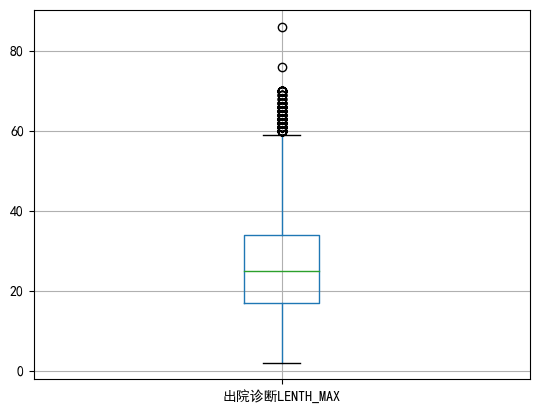

In [77]:
# 缺失值填充
emp_col = '出院诊断LENTH_MAX'
#  先观察箱图
data.boxplot(column=emp_col)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.show()

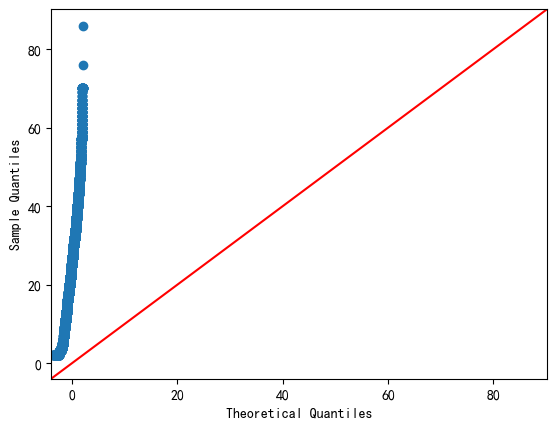

In [82]:
# 观察qq图
sm.qqplot(data[emp_col],line='45')
plt.show()
# 存在重尾情况或右偏情况，null值采用中位数进行填充

In [92]:
# 采用中位数进行数据填充
data[emp_col].fillna(np.median(data[~np.isnan(data[emp_col])]),inplace=True)
data[emp_col]

0        29.0
1        20.0
2        29.0
3        16.0
4        33.0
         ... 
15995    28.0
15996    25.0
15997    30.0
15998     5.0
15999    34.0
Name: 出院诊断LENTH_MAX, Length: 16000, dtype: float64

In [93]:
# 删除每列只有一种值的列
for col in data.columns.tolist():
    count = len(data[col].unique())
    print(count)
    if count==1:
        data = data.drop(col,axis=1)
# 只有一列被删除

65
7
31
224
8
52
190
57
267
15722
15936
15562
15856
137
485
15903
15960
15774
15888
9
1
15610
15936
15929
15548
15852
6890
15847
4983
13542
8479
3002
237
3410
362
5604
376
4968
45
5
44
157
136
7760
36
893
16
615
8
6665
26
15480
279
2
15918
344
2286
6035
15571
15938
2303
280
7
2277
10
30
72
15943
11428
12340
1229
15950
2454
2
2
2
2


In [94]:
# 删除重复的行
data.drop_duplicates(inplace=True)

In [95]:
data

,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,0,6,7,5.666667,3,2.166667,34,7,5.666667,3501.18,...,0.939194,4.262371e-03,0.050817,0.0,0.007434,0.0,0,0,1,0
1,0,6,4,2.500000,2,1.333333,15,4,2.500000,2217.66,...,0.955626,2.981609e-03,0.030815,0.0,0.013398,0.0,0,0,1,0
2,8,6,8,6.166667,3,2.166667,45,9,7.500000,3360.55,...,0.783610,3.321330e-04,0.000000,0.0,0.195087,0.0,0,0,0,0
3,0,6,6,3.666667,2,1.833333,23,6,3.833333,3030.61,...,0.458649,1.843500e-04,0.000000,0.0,0.541351,0.0,0,0,0,0
4,0,6,5,4.333333,1,1.000000,26,5,4.333333,2332.45,...,0.983726,3.163870e-04,0.000000,0.0,0.016274,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0,6,8,6.500000,3,3.000000,40,8,6.666667,2831.13,...,0.986674,5.260850e-04,0.000000,0.0,0.013326,0.0,0,0,1,0
15996,0,6,8,6.833333,2,2.000000,42,9,7.000000,2369.03,...,0.927005,6.890000e-05,0.008665,0.0,0.039553,0.0,1,0,0,0
15997,4,6,8,6.333333,2,2.000000,42,9,7.000000,5421.56,...,0.773433,6.738972e-03,0.002232,1.0,0.223888,0.0,0,0,1,0
15998,0,6,5,3.333333,1,1.000000,20,5,3.333333,5270.74,...,0.967045,7.680000e-07,0.025627,0.0,0.006425,0.0,0,0,0,0


In [96]:
## 进行异常值处理

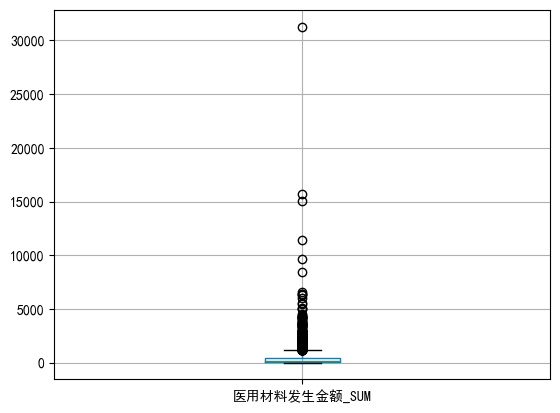

In [97]:
# 1，画箱线图
data.boxplot(column='医用材料发生金额_SUM')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.show()
# 发现多数的列呈右偏，故此处不用箱图进行异常值处理，采用缩尾处理

In [98]:
# 采用缩尾处理
for col in data.columns:
    if data[col].dtype is np.dtype('int64'):    #不对离散类型数据进行该处理
        continue
    df = data[col].tolist()
    def Winsorization_outliers(df):
        q1 = np.percentile(df,1)
        q3 = np.percentile(df,99)
        data.col[data.col>q3]=q3
        data.col[data.col<q1]=q1

In [99]:
data

,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,0,6,7,5.666667,3,2.166667,34,7,5.666667,3501.18,...,0.939194,4.262371e-03,0.050817,0.0,0.007434,0.0,0,0,1,0
1,0,6,4,2.500000,2,1.333333,15,4,2.500000,2217.66,...,0.955626,2.981609e-03,0.030815,0.0,0.013398,0.0,0,0,1,0
2,8,6,8,6.166667,3,2.166667,45,9,7.500000,3360.55,...,0.783610,3.321330e-04,0.000000,0.0,0.195087,0.0,0,0,0,0
3,0,6,6,3.666667,2,1.833333,23,6,3.833333,3030.61,...,0.458649,1.843500e-04,0.000000,0.0,0.541351,0.0,0,0,0,0
4,0,6,5,4.333333,1,1.000000,26,5,4.333333,2332.45,...,0.983726,3.163870e-04,0.000000,0.0,0.016274,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0,6,8,6.500000,3,3.000000,40,8,6.666667,2831.13,...,0.986674,5.260850e-04,0.000000,0.0,0.013326,0.0,0,0,1,0
15996,0,6,8,6.833333,2,2.000000,42,9,7.000000,2369.03,...,0.927005,6.890000e-05,0.008665,0.0,0.039553,0.0,1,0,0,0
15997,4,6,8,6.333333,2,2.000000,42,9,7.000000,5421.56,...,0.773433,6.738972e-03,0.002232,1.0,0.223888,0.0,0,0,1,0
15998,0,6,5,3.333333,1,1.000000,20,5,3.333333,5270.74,...,0.967045,7.680000e-07,0.025627,0.0,0.006425,0.0,0,0,0,0
